In [5]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import save_model, load_model

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


import re
import numpy as np
import os
import time
import json
import pickle
import ast
import cv2

from glob import glob
from PIL import Image
from tqdm import tqdm

In [6]:
print("Versão do TensorFlow:", tf.__version__)

Versão do TensorFlow: 2.13.0


In [7]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [98]:
# Configuration
SEP = " -<>- "
IMG_SIZE = 299
MAX_LENGTH = 9


PATH = "C:/Users/fabri/OneDrive/Área de Trabalho/BarchartReverseEngineering/dataset/train"
IMG_PATH = PATH + "/plots/"
BARS_PATH = PATH + "/train_barbbox.idl"
IMGSIZE_PATH = PATH + "/train_imgsize.idl"

START_TOKEN = [1.0, 1.0, 0.0] 
END_TOKEN = [0.0, 0.0, 0.0]

In [124]:
# utilities

def get_normalized_data(bbox, real_imgsize):
    '''
    return bar's center coordinate and height

    Parameters:
    bbox (list): [x1, y1, x2, y2]
    real_imgsize (tuple): (imgsize, bar_direction)
    '''
    
    imgsize, bar_direction = real_imgsize
    # top-left and bottom-right x coordinates divided by image width
    bbox[0] /= imgsize[0]
    bbox[2] /= imgsize[0]
    # top-left and bottom-right y coordinates divided by image height
    bbox[1] /= imgsize[1]
    bbox[3] /= imgsize[1]
    
    # normalized height
    if bar_direction == "vertical":
        height = abs(bbox[3] - bbox[1])
        result = [bbox[3], bbox[1], height]
    else:
        height = abs(bbox[2] - bbox[0])
        result = [bbox[2], bbox[0], height]

    return result

def load_image(image_path):
    img = tf.io.read_file(image_path)
    # decode_jpeg also works for png
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, image_path

In [125]:
all_bars = []
all_img_name_vector = []

# BAR_PATH = "C:/Users/fabri/OneDrive/Área de Trabalho/BarchartReverseEngineering/data/train/train_barbbox.idl"
# IMGSIZE_PATH = "C:/Users/fabri/OneDrive/Área de Trabalho/BarchartReverseEngineering/data/train/train_imgsize.idl"


with open(BARS_PATH, "r") as fbar, open(IMGSIZE_PATH, "r") as fsize:
    # fsize is the file that contains the image size
    # fbar is the file that contains the bar's bounding box

    for bars, imgsize in tqdm(zip(fbar, fsize)):
        bars = bars.strip() #remove \n
        imgsize = imgsize.strip() #remove \n
        bars = bars.split(SEP) # split by separator
        imgsize = imgsize.split(SEP) # split by separator
        assert bars[0] == imgsize[0], "image name not match!" # check if the image name is the same
        
        all_img_name_vector.append(IMG_PATH + bars[0]) # add image path to the vector
        boxs = ast.literal_eval(bars[1]) # convert string to list
        imgsize = ast.literal_eval(imgsize[1]) # convert string to tuple
        one_img_bar = [START_TOKEN] # start-token 
        
        for box in boxs:
            bbox = box["bbox"]
            bar_info = get_normalized_data(bbox, imgsize)
            one_img_bar.append(bar_info)
        one_img_bar.append(END_TOKEN) # end-token
        # padding the sequence
        if len(one_img_bar) < MAX_LENGTH + 2:
            need = MAX_LENGTH + 2 - len(one_img_bar)
            for i in range(need):
                one_img_bar.append(END_TOKEN)
        
        all_bars.append(one_img_bar)

bars_vector, img_name_vector = shuffle(all_bars, all_img_name_vector, random_state=1)

30000it [00:07, 4219.21it/s]


First value: Y coordinate of the center of the bar.

Second value: X-coordinate of the center of the bar.

Third value: Normalized bar height.

In [ ]:
# *** unit test section ***
print(len(bars_vector[0]), len(img_name_vector[0]))
print(bars_vector[0])
print(img_name_vector[0])

11 103
[[1.0, 1.0, 0.0], [0.6014492753623188, 0.1497584541062802, 0.45169082125603865], [0.855072463768116, 0.1497584541062802, 0.7053140096618358], [0.8260869565217391, 0.1497584541062802, 0.6763285024154589], [0.5024154589371981, 0.1497584541062802, 0.3526570048309179], [0.8623188405797102, 0.1497584541062802, 0.71256038647343], [0.8502415458937198, 0.1497584541062802, 0.7004830917874396], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
C:/Users/fabri/OneDrive/Área de Trabalho/BarchartReverseEngineering/dataset/train/plots/train_10747.png


In [ ]:
print(len(img_name_vector), len(bars_vector))

30000 30000


In [ ]:
max_length = MAX_LENGTH + 2

# higher some data just to test the model
# img_name_vector = img_name_vector[:int(len(img_name_vector) * 1/50)]
# bars_vector = bars_vector[:int(len(bars_vector) * 1/50)]

# Create training and validation sets
img_name_train, img_name_val, bar_train, bar_val = train_test_split(img_name_vector, bars_vector, test_size=0.04, random_state=0)

In [ ]:
len(img_name_train), len(bar_train), len(img_name_val), len(bar_val)

(28800, 28800, 1200, 1200)

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 32 
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
barinfo_size = 3
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 100

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
    #img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    img_tensor, _ = load_image(img_name)
    return img_tensor, cap

In [ ]:
# create tf dataset object 
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, bar_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.float32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Attention Model

This class implements the Bahdanau attention mechanism, which is used to calculate attention weights in a neural translation model called Seq2Seq. Bahdanau attention is a form of alignment-based attention that allows the model to focus on different parts of the input while generating the output. In this specific case, the attention is applied to input features generated by a CNN encoder layer.

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    # units: dimension of the hidden layer
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features: CNN_encoder output
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden: hidden state of the RNN_decoder (last state)
    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)

    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    #print("feature:", features.shape)
    #print("hidden:", hidden_with_time_axis.shape)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    #print("context:", context_vector.shape)

    return context_vector, attention_weights

### Encoder

This class represents a CNN encoder. It is used to extract features from an input image. It has a pre-trained convolutional neural network (CNN) layer, which is used to extract features from the image. The extracted features are then passed through a dense (fully connected) layer to properly scale them.

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

        # load the pre-trained model      
        image_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', pooling=None)
        new_input = image_model.input
        hidden_layer = image_model.output

        # receive the input and output of the pre-trained model
        self.image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
        L = len(self.image_features_extract_model.layers)
        
        # last 10 layers are trainable, others are not trainable
        for i, layer in enumerate(self.image_features_extract_model.layers):
          if i < L - 10:
            layer.trainable = False
          else:
            layer.trainable = True

    def call(self, x):
        x = self.image_features_extract_model(x)
        x = tf.reshape(x, [x.shape[0], -1, x.shape[-1]]) # (batch_size, 64, embedding_dim)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### Decoder

This class is responsible for decoding in a Seq2Seq model. It uses an RNN decoder layer (in this case, a GRU layer) to generate the output sequence based on the input features and the hidden state from the previous decoder step. It also uses the Bahdanau attention mechanism to weight the input features according to their relative importance at each decoding step.

In [ ]:
class RNN_Decoder(tf.keras.Model):
  # RNN_decoder: LSTM
  # embedding_dim: dimension of the embedding layer
  # units: dimension of the hidden layer
  # barinfo_size: dimension of the bar information
  def __init__(self, embedding_dim, units, barinfo_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    # embedding layer to transform the input into a vector of dimension embedding_dim 
    self.embedding = tf.keras.layers.Dense(embedding_dim, activation="relu")
    # GRU: a type of RNN
    self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units, activation="relu")
    self.fc2 = tf.keras.layers.Dense(barinfo_size, activation="relu")

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, state):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, state)
    
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    # Concatenate the input vector x with the context vector to incorporate relevant information from both the previous bar and the attention-based context. 
    # This allows the decoder to consider both the local information (previous bar) and the global context (graph features) when generating the next bar information.  
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    #print("x:", x.shape)
    #output: a batch of sequences of vectors of dimension units
    #state: the last hidden state of the GRU
    output, state= self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, barinfo_size)

In [ ]:
# Define the optimizer and the loss function

# learning rate decay schedule (exponential decay)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=500, decay_rate=0.96, staircase=True)

# update the weights of the model using the stochastic gradient descent (SGD) optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
#optimizer = tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.RMSprop()

# loss function
loss_object = tf.keras.losses.MeanSquaredError()

def loss_function(real, pred):
    loss_ = loss_object(real, pred)
    return tf.reduce_mean(loss_)

========================================================================================================

In [ ]:
checkpoint_path = "model_checkpoint"

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1]) * 5

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(f"Restoring from previous step {start_epoch} ...")
else:
    print("Training from scratch ...")

Restoring from previous step 200 ...


========================================================================================================

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the target are not related from image to image
  state = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([START_TOKEN] * BATCH_SIZE, 1)

  # gradient 
  with tf.GradientTape() as tape:
      # getting the output from the encoder
      features = encoder(img_tensor) # (batch_size, 64, embedding_dim) 

      # for each bar in the target sequence
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, state, _ = decoder(dec_input, features, state)
          
          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  # averaging the loss
  total_loss = (loss / int(target.shape[1]))

  # getting the trainable variables
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  # calculating the gradients
  gradients = tape.gradient(loss, trainable_variables)

  # updating the weights
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 500

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.8f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

    loss_plot.append(total_loss / num_steps)

    # Dentro do loop de épocas
    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.8f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 201 Batch 0 Loss 0.03156832
Epoch 201 Batch 100 Loss 0.02910696
Epoch 201 Batch 200 Loss 0.02735596
Epoch 201 Batch 300 Loss 0.03122565
Epoch 201 Batch 400 Loss 0.02903866
Epoch 201 Batch 500 Loss 0.02903399
Epoch 201 Batch 600 Loss 0.02784901
Epoch 201 Batch 700 Loss 0.02855339
Epoch 201 Batch 800 Loss 0.03165116
Epoch 201 Loss 0.03016038
Time taken for 1 epoch 465.9203636646271 sec

Epoch 202 Batch 0 Loss 0.02654491
Epoch 202 Batch 100 Loss 0.02902162
Epoch 202 Batch 200 Loss 0.02888108
Epoch 202 Batch 300 Loss 0.02636969
Epoch 202 Batch 400 Loss 0.03121053
Epoch 202 Batch 500 Loss 0.03053529
Epoch 202 Batch 600 Loss 0.02874866
Epoch 202 Batch 700 Loss 0.03384474
Epoch 202 Batch 800 Loss 0.03224752
Epoch 202 Loss 0.03008706
Time taken for 1 epoch 441.5528185367584 sec

Epoch 203 Batch 0 Loss 0.02901881
Epoch 203 Batch 100 Loss 0.02976460
Epoch 203 Batch 200 Loss 0.03138809
Epoch 203 Batch 300 Loss 0.03092101
Epoch 203 Batch 400 Loss 0.02973909
Epoch 203 Batch 500 Loss 0.0316702

KeyboardInterrupt: 

In [ ]:
loss_plot

[<tf.Tensor: shape=(), dtype=float32, numpy=0.030160384>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.03008706>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.030019417>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.029958246>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.029901665>]

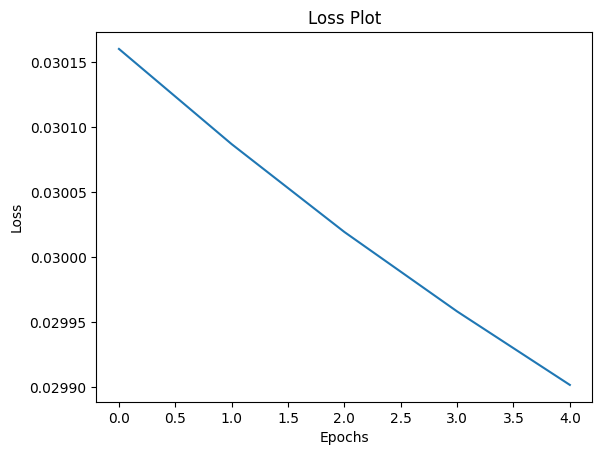

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    # Initialize the attention plot matrix
    attention_plot = np.zeros((max_length, attention_features_shape))

    # Reset the hidden state of the decoder for each evaluation
    hidden = decoder.reset_state(batch_size=1)

    # Preprocess the image and extract relevant features using the encoder
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    features = encoder(temp_input)

    # Set the initial input for the decoder as the start token
    dec_input = tf.expand_dims([START_TOKEN], 0)
    result = []

    # Generate predictions and attention weights for each step up to the maximum length
    # max_length is the maximum length of the target sentence
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        # Store the attention weights in the attention plot matrix
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # Convert the predictions to a numpy array
        predictions = predictions.numpy()

        # Check if the sum of predictions is below a threshold to end the sequence
        if np.sum(predictions[0]) < 0.1:
            break
            
        # Append the predictions to the result list
        result.append(predictions[0])

        # Update the decoder input with the predictions for the next step
        dec_input = tf.expand_dims(predictions, 0)

    # Trim the attention plot matrix to match the length of the result list
    attention_plot = attention_plot[:len(result), :]

    # Return the result list and the attention plot matrix
    return result, attention_plot


## Predictions

In [ ]:
# extractions on the validation set
image = img_name_val[0]
target = bar_val[0]
print(image)
print(target)

result, attention_plot = evaluate(image)

C:/Users/fabri/OneDrive/Área de Trabalho/BarchartReverseEngineering/dataset/train/plots/train_20823.png
[[1.0, 1.0, 0.0], [0.9053571428571429, 0.2017857142857143, 0.7035714285714285], [0.9053571428571429, 0.13035714285714287, 0.775], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]


In [ ]:
print('Real: ', target)
print('Pred: ', result)

Real:  [[1.0, 1.0, 0.0], [0.9053571428571429, 0.2017857142857143, 0.7035714285714285], [0.9053571428571429, 0.13035714285714287, 0.775], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
Pred:  [array([0.8272145, 0.2037313, 0.6269537], dtype=float32), array([0.55684614, 0.15030047, 0.4026751 ], dtype=float32), array([0.4031955 , 0.05066801, 0.3351081 ], dtype=float32), array([0.2072431 , 0.        , 0.19162937], dtype=float32)]


In [ ]:
draw_rectangles(image, result)

## Attention

c:\Users\fabri\anaconda\envs\poco\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


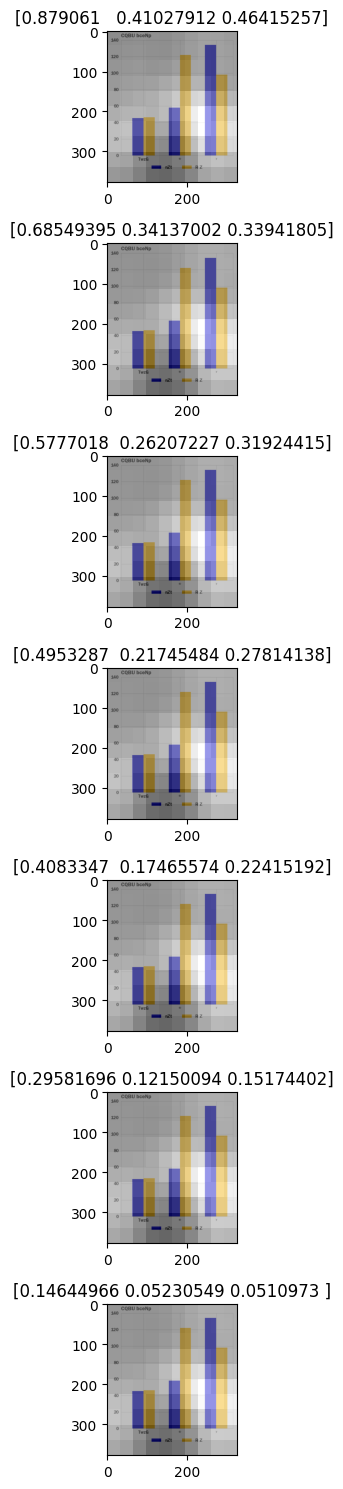

In [ ]:
plot_attention(image, result, attention_plot)
# opening the image
#Image.open(img_name_train[rid])